In [1]:
from google.colab import drive
drive.mount('/content/drive')

import gc
gc.enable()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

import imblearn #for imbalanced dataset
from imblearn.pipeline import Pipeline #over or under sampling passed only during training as opposed to sklearn which does it in both training and testing
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN #generates new samples to match the no with the class having highest no of samples
from imblearn.under_sampling import RandomUnderSampler #randomly selects samples from the higher classes to match the number in the lowest class

RANDOM_SEED = 42

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
data = pd.read_csv("/content/drive/MyDrive/Womens_Data/data.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [4]:
# Checking for errors like nan values, spelling mistakes etc in the dataset
categorical_cols = ['Division Name', 'Department Name', 'Class Name']
for col in categorical_cols:
    print(f'\nUnique values in column: {col}')
    print(data[col].unique())


Unique values in column: Division Name
['Initmates' 'General' 'General Petite' nan]

Unique values in column: Department Name
['Intimate' 'Dresses' 'Bottoms' 'Tops' 'Jackets' 'Trend' nan]

Unique values in column: Class Name
['Intimates' 'Dresses' 'Pants' 'Blouses' 'Knits' 'Outerwear' 'Lounge'
 'Sweaters' 'Skirts' 'Fine gauge' 'Sleep' 'Jackets' 'Swim' 'Trend' 'Jeans'
 'Legwear' 'Shorts' 'Layering' 'Casual bottoms' nan 'Chemises']


In [5]:
# Correcting "Initmates" in division name
data['Division Name'].apply(lambda x: 'Intimates' if x == 'Initmates' else x)

# we did this to check whether the ratings and reviews are affected on the basis of the product category

# Filling nan values with 'Other'
data[categorical_cols] = data[categorical_cols].fillna('Other')

Reviews where no text is present:  844


<Axes: >

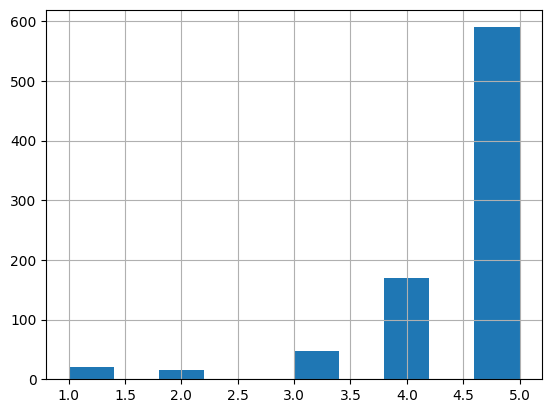

In [6]:
# Exploring the ratings of the reviews where there is no text and no title
print(f'Reviews where no text is present: ', len(data[data['Title'].isnull() & data['Review Text'].isnull()]['Rating']))

data[data['Title'].isnull() & data['Review Text'].isnull()]['Rating'].hist()

In [7]:
# Removing entries with no review text and title
data = data[~(data['Title'].isnull() & data['Review Text'].isnull())]

In [8]:
data['Title'] = data['Title'].fillna('Title')
data['Review Text'] = data['Review Text'].fillna('Review')

In [9]:
data.head()


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,Title,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,Title,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


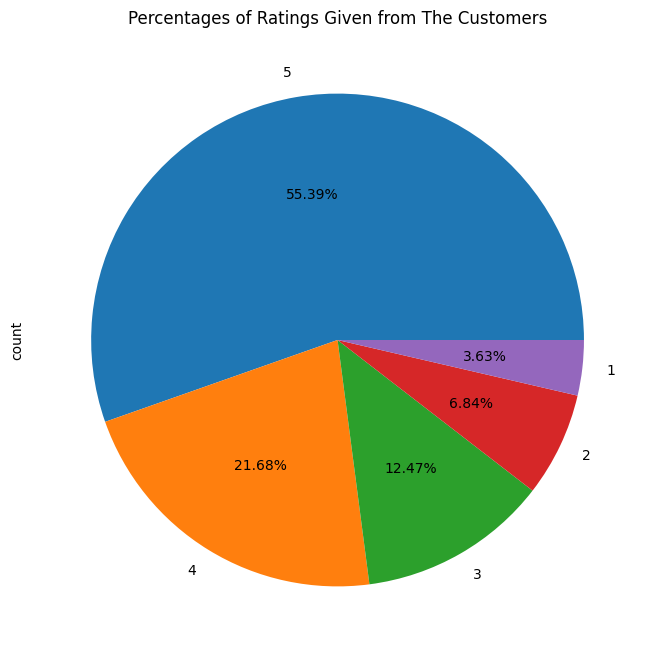

In [10]:
data.Rating.value_counts().plot(kind = "pie", legend = False, autopct = "%1.2f%%", fontsize = 10, figsize=(8,8))
plt.title("Percentages of Ratings Given from The Customers", loc = "center")
plt.show()

In [11]:
data['feature_review'] = data[['Title', 'Review Text']].agg(' '.join, axis=1)
data.isnull().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,0
Department Name,0


In [12]:
data[['Title', 'feature_review']].head()

,Title,feature_review
0,Title,Title Absolutely wonderful - silky and sexy an...
1,Title,Title Love this dress! it's sooo pretty. i h...
2,Some major design flaws,Some major design flaws I had such high hopes ...
3,My favorite buy!,"My favorite buy! I love, love, love this jumps..."
4,Flattering shirt,Flattering shirt This shirt is very flattering...


In [13]:
data = pd.get_dummies(data, columns=categorical_cols)

In [14]:
# Generating text sentiment score

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords

nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sid = SentimentIntensityAnalyzer()

text_columns = ['Title', 'Review Text', 'feature_review']

for col in text_columns:
    # Tokenization
    data[f'{col}_processed'] = data[col].apply(wordpunct_tokenize)

    # Lemmatization
    data[f'{col}_processed'] = data[f'{col}_processed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

    # Removing stopwords
    data[f'{col}_processed'] = data[f'{col}_processed'].apply(lambda x: [word for word in x if word not in stop_words])

    # Calculating compound sentiment for both processed and unprocessed text
    data[f'{col}_sentiment'] = data[col].apply(lambda x: sid.polarity_scores(x)['compound']) #for normal text which was in the original dataset
    data[f'{col}_processed_sentiment'] = data[f'{col}_processed'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound']) #for processed text where we have done above processing

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<Axes: >

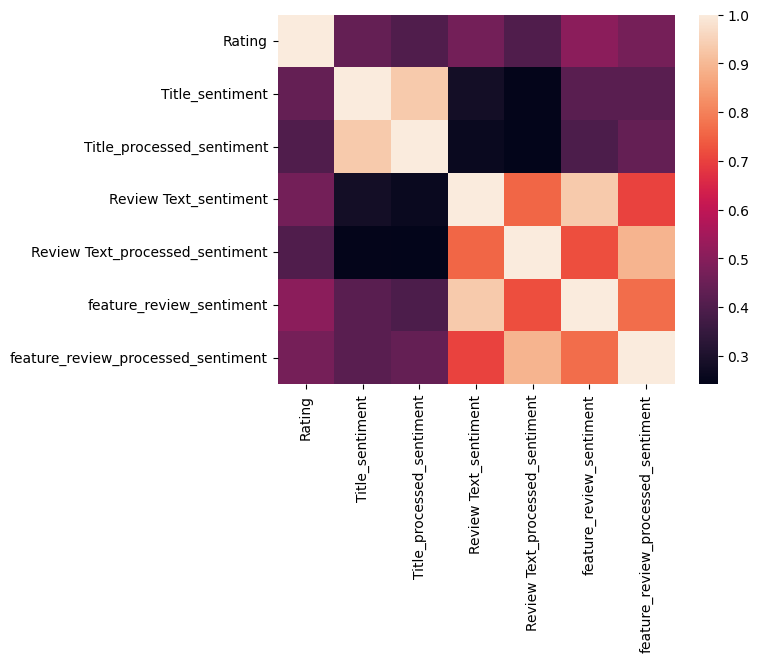

In [15]:
# Visualizing the correlation between rating and the new sentiment columns
sentiment_columns = ['Rating']
for col in text_columns:
    sentiment_columns += [f'{col}_sentiment', f'{col}_processed_sentiment']
sns.heatmap(data[sentiment_columns].corr())

In [16]:
# defining the feature columns for training

cols = list(data.columns)
features = [col for col in cols if col not in ['Unnamed: 0', 'Clothing ID', 'Rating', 'Title_processed', 'Review Text_processed', 'feature_review_processed']+text_columns]
print(len(features))

# defining training data
X = data[features].astype('float16') #all numerical features which we have created above. They are in float16 to reduce the space that they occupy
y = data['Rating'].astype(np.uint8) #rating is target. uint is unsigned integer to reduce space
#we were experimenting with another approach where we were using word vectors and dataset size increased hence we did the above

41


In [17]:
# Model training
# Baseline experiment

clfs = [
    ('rf', RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
    ('lgb', LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1)),
    ('dart', LGBMClassifier(boosting_type='dart', random_state=RANDOM_SEED, n_jobs=-1)),
    ('lr', LogisticRegression(random_state=RANDOM_SEED, n_jobs=-1))
]

# sampler options
# SMOTE
# BorderlineSMOTE
# SVMSMOTE
# ADASYN
# RandomUnderSampler

#sampler where we define oversampling or undersampling. For ex in SMOTE, where the data is imbalanced like 5 star rating could be the major rating hence in overssampling we can have all ratings at the same level
#
def test_clfs(classifiers, sampler=None, scaler=None):

    for name, clf in classifiers:

        # pipeline to scale and over/under sample data
        steps = []
        #steps list exists to add a scaler, sampler and classifier and then this list will execute in a left to right basis meaning first scaler, then sampler, then classifier. We did this to not do it manually while training the model
        if scaler == None:
            pass
        else:
            steps = [('scaler', scaler)]

        if sampler == None:
            pass
        else:
            steps += [('sampler', sampler)]

        steps += [('classifier', clf)]
        model = Pipeline(steps=steps)

        # cross-validation generator
        cv = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

        # cross validation scores
        scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)#n_jobs -1 used to speed up the process of training, -1 means "use all available processors"
        print(f'F1 Score: {np.mean(scores):.5f} ± {np.std(scores):.5f} | {name}') #since we have 5 splits to generate 5 scores

        #we changed from f1_macro to f1_weighted because of class imbalance
# We tried using over and under sampling techniques such as SMOTE and RandomUnderSampler
# However, both seemed to result in a worse overall performance
#if we would have used f1_macro or f1_micro, we would've had a lower f1 score because they do not take into account the class imbalance
test_clfs(clfs, None, MinMaxScaler())

F1 Score: 0.59161 ± 0.00341 | rf
F1 Score: 0.59480 ± 0.00331 | lgb
F1 Score: 0.59406 ± 0.00456 | dart
F1 Score: 0.56768 ± 0.00420 | lr


In [18]:
# Using only those reviews where the positive feedback count is not zero
X_train, X_val, y_train, y_val = train_test_split(data[data['Positive Feedback Count']>0][features],
                                                  data[data['Positive Feedback Count']>0]['Rating'],
                                                  test_size=0.2, random_state=RANDOM_SEED)

# Since LightGBM was the highest performing model, we're using it for validation
clf = Pipeline(steps = [('scaler', MinMaxScaler()),
                        ('classifier', LGBMClassifier(random_state=RANDOM_SEED, n_jobs=-1, verbosity=-1))])

clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1))])

In [19]:
from sklearn.metrics import f1_score

print(f'Weighted F1 score on the validation set (without reviews that have zero positive feedback count): {f1_score(y_val, clf.predict(X_val), average="weighted"):.4f}')
print(f'Weighted F1 score on the entire dataset: {f1_score(y, clf.predict(X), average="weighted"):.4f}')

Weighted F1 score on the validation set (without reviews that have zero positive feedback count): 0.6025
Weighted F1 score on the entire dataset: 0.6912


The above results show that training the model only on reviews that have at least ONE positive feedback count improves the performance. This step essentially filters out the reviews that no user found useful
Furthermore, using over/under sampling techniques like SMOTE or Random Under Sampling seemed to worsen the classifier performance
Using the MinMaxScaler to normalize the data yielded better results over using StandardScaler or no scaler

Text(0.5, 0, 'Rating')

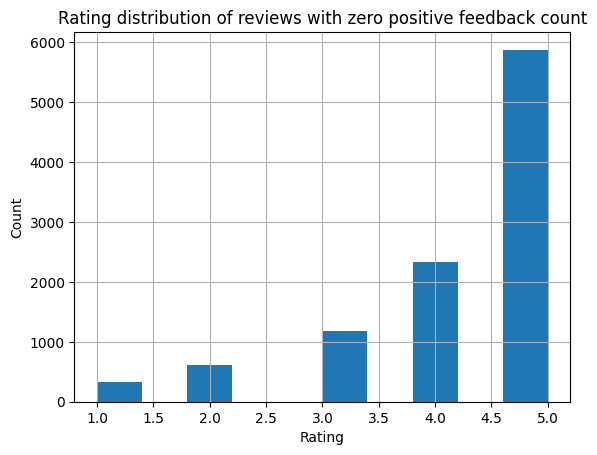

In [20]:
data[data['Positive Feedback Count'] == 0]['Rating'].hist()
plt.title('Rating distribution of reviews with zero positive feedback count')
plt.ylabel('Count')
plt.xlabel('Rating')